In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio

import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec

In [3]:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# Load the "area" DataFrame

area_data = pd.read_csv("https://github.com/christianhof/BioScen1.5_SDM/raw/master/data/realm_coordinates.csv")
area_latitudes = area_data['y']
area_longitudes = area_data['x']

luh_area = pd.DataFrame()
# Load the land use datasets for SSP126 and SSP460
ncfname_ssp126 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc"
ncfname_ssp460 = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp460.nc"
da_landuse_ssp126 = xr.open_dataset(ncfname_ssp126, decode_times=False)
da_landuse_ssp460 = xr.open_dataset(ncfname_ssp460, decode_times=False)

luh_area_latitudes = da_landuse_ssp126["lat"].values
luh_area_longitudes = da_landuse_ssp126["lon"].values


# Define the category mapping
category_mapping = {
    'cropland': ['c3ann', 'c3per', 'c4ann', 'c4per', 'c3nfx'],
    'pasture': ['pastr', 'range'],
    'forested land': ['primf', 'secdf'],
    'non-forested land': ['primn', 'secdn']
}

# Get the time values
time_ssp126 = da_landuse_ssp126['time'].values
time_ssp460 = da_landuse_ssp460['time'].values
years_ssp126 = np.arange(2015, 2015 + len(time_ssp126))
years_ssp460 = np.arange(2015, 2015 + len(time_ssp460))


# Create an empty array to store area values
area_values = np.zeros_like(da_landuse_ssp126['primf'].isel(time=0))

# Loop over latitude and longitude indices
for lat_idx, lat in enumerate(da_landuse_ssp126['lat']):
    for lon_idx, lon in enumerate(da_landuse_ssp126['lon']):
        # Find the corresponding area value based on latitude and longitude in area_data
        area_idx = (area_latitudes == lat) & (area_longitudes == lon)
        
        if np.any(area_idx):
            # Get the area value for this grid cell
            area_per_cell = area_data.loc[area_idx, 'area'].values[0]
            # Set the area value in the area_values array
            area_values[lat_idx, lon_idx] = area_per_cell

# Add the "area" variable to the da_landuse_ssp126 dataset
da_landuse_ssp126["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": da_landuse_ssp126['lat'], "lon": da_landuse_ssp126['lon']})

# Initialize the modified land use datasets
modified_landuse_ssp126 = da_landuse_ssp126.copy()


# Loop over the data variables and convert the values to Mkm² for SSP126
for variable in da_landuse_ssp126.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp126[variable] = da_landuse_ssp126["area"] * da_landuse_ssp126[variable]  / 1e6


# Create an empty array to store area values
area_values = np.zeros_like(da_landuse_ssp460['primf'].isel(time=0))

# Loop over latitude and longitude indices
for lat_idx, lat in enumerate(da_landuse_ssp460['lat']):
    for lon_idx, lon in enumerate(da_landuse_ssp460['lon']):
        # Find the corresponding area value based on latitude and longitude in area_data
        area_idx = (area_latitudes == lat) & (area_longitudes == lon)
        
        if np.any(area_idx):
            # Get the area value for this grid cell
            area_per_cell = area_data.loc[area_idx, 'area'].values[0]
            # Set the area value in the area_values array
            area_values[lat_idx, lon_idx] = area_per_cell

# Add the "area" variable to the da_landuse_ssp126 dataset
da_landuse_ssp460["area"] = xr.DataArray(area_values, dims=("lat", "lon"), coords={"lat": da_landuse_ssp460['lat'], "lon": da_landuse_ssp460['lon']})

modified_landuse_ssp460 = da_landuse_ssp460.copy()
for variable in da_landuse_ssp460.data_vars:
    
    # Assign the converted values to the modified_landuse_ssp126 dataset
    modified_landuse_ssp460[variable] = da_landuse_ssp460["area"] * da_landuse_ssp460[variable]  / 1e6

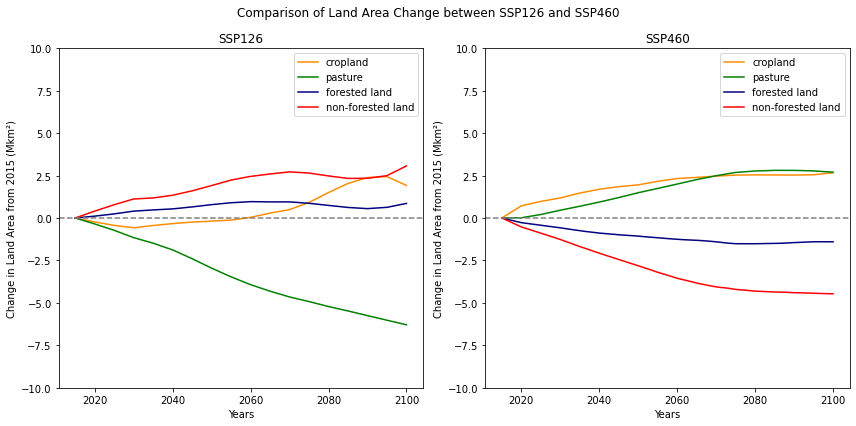

<Figure size 432x288 with 0 Axes>

In [129]:



# Calculate the sum of values for each variable for SSP126
sum_over_values_ssp126 = modified_landuse_ssp126.sum(dim=[dim for dim in modified_landuse_ssp126.dims if dim != 'time'])

# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Calculate the difference to Year 0 for each variable for SSP126
difference_ssp126 = sum_over_values_ssp126 - sum_over_values_ssp126.isel(time=0)

# Create a new dataset for sum over categories for SSP126
sum_over_categories_ssp126 = xr.Dataset()

# Sum the differences for cropland category for SSP126
sum_over_categories_ssp126['cropland'] = sum_over_values_ssp126['c3ann'] + sum_over_values_ssp126['c3per'] + sum_over_values_ssp126['c4ann'] + sum_over_values_ssp126['c4per'] + sum_over_values_ssp126['c3nfx']

# Sum the differences for pasture category for SSP126
sum_over_categories_ssp126['pasture'] = sum_over_values_ssp126['pastr'] + sum_over_values_ssp126['range']

# Sum the differences for forest category for SSP126
sum_over_categories_ssp126['forested land'] = sum_over_values_ssp126['primf'] + sum_over_values_ssp126['secdf']

# Sum the differences for natural_land category for SSP126
sum_over_categories_ssp126['non-forested land'] = sum_over_values_ssp126['primn'] + sum_over_values_ssp126['secdn']

# Calculate the difference to Year 0 for each category for SSP126
difference_ssp126 = sum_over_categories_ssp126 - sum_over_categories_ssp126.isel(time=0)


# Calculate the sum of values for each variable for SSP460
sum_over_values_ssp460 = modified_landuse_ssp460.sum(dim=[dim for dim in modified_landuse_ssp460.dims if dim != 'time'])

# Create a new dataset for sum over categories for SSP460
sum_over_categories_ssp460 = xr.Dataset()

# Sum the differences for cropland category for SSP460
sum_over_categories_ssp460['cropland'] = sum_over_values_ssp460['c3ann'] + sum_over_values_ssp460['c3per'] + sum_over_values_ssp460['c4ann'] + sum_over_values_ssp460['c4per'] + sum_over_values_ssp460['c3nfx']

# Sum the differences for pasture category for SSP460
sum_over_categories_ssp460['pasture'] = sum_over_values_ssp460['pastr'] + sum_over_values_ssp460['range']

# Sum the differences for forest category for SSP460
sum_over_categories_ssp460['forested land'] = sum_over_values_ssp460['primf'] + sum_over_values_ssp460['secdf']

# Sum the differences for natural_land category for SSP460
sum_over_categories_ssp460['non-forested land'] = sum_over_values_ssp460['primn'] + sum_over_values_ssp460['secdn']

# Calculate the difference to Year 0 for each category for SSP460
difference_ssp460 = sum_over_categories_ssp460 - sum_over_categories_ssp460.isel(time=0)


# Set the category colors
category_colors = {
    'cropland': '#FF8C00',
    'pasture': 'green',
    'forested land': '#000080',
    'non-forested land': 'red'
}


# Create a figure and axes for SSP126
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot SSP126 data
for category in category_mapping:
    values_ssp126 = difference_ssp126[category].values
    ax1.plot(years_ssp126, values_ssp126, label=category, color=category_colors[category])

ax1.axhline(y=0.0, color='grey', linestyle='--')
ax1.set_xlabel('Years')
ax1.set_ylabel('Change in Land Area from 2015 (Mkm²)')
ax1.set_ylim(-10, 10)
ax1.legend()
ax1.set_title("SSP126")


# Plot SSP460 data
for category in category_mapping:
    values_ssp460 = difference_ssp460[category].values
    ax2.plot(years_ssp460, values_ssp460, label=category, color=category_colors[category])

ax2.axhline(y=0.0, color='grey', linestyle='--')
ax2.set_xlabel('Years')
ax2.set_ylabel('Change in Land Area from 2015 (Mkm²)')
ax2.set_ylim(-10, 10)
ax2.legend()
ax2.set_title("SSP460")


# Add a suptitle
fig.suptitle("Comparison of Land Area Change between SSP126 and SSP460")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/final_figures/Figure_1")
